In [157]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [158]:
file = open('./.env')
api = file.read()

# Data Collection

__API Request/OAuth__

In [159]:
def search_igdb(n): 
  
    #set up an empty list to append each API call
    output = []
    url = 'https://api-v3.igdb.com/games/?limit=50'
    #establish URL and api_key
    headers = {
    'user-key': api,
    'accept': 'application/json'
     }
    #loops through a list of n length and updates offset after each call
    for i in list(range(n)): 
        offset = 0
        offset += 50*i 
        url_params = {
            'fields':'name, total_rating_count, total_rating, rating_count, rating, popularity, aggregated_rating, aggregated_rating_count, themes, platforms, first_release_date, player_perspectives, hypes, game_modes, game_engines, genres', 
            #'filter[release_dates.platform][any]': '48,49,6',
            'filter[total_rating_count][gte]': '150',
            'filter[rating_count][gte]': '100',
            'filter[aggregated_rating_count][gte]': '10',
            'offset': offset
      
      
      
    #         'filter'= filter[release_dates.platform][any] = 48,49,6
    #         'filter'= filter[total_rating_count][gte] = 1
          }
        #fields=*&filter[release_dates.platform][any]=48,49,6
    
    
        response = requests.get(url, headers=headers, params=url_params)
        #run our request get requests
    
  
    
        list(filter(lambda x: output.append(x), response.json()))
     #and 
  
    return output

In [160]:
video_games = search_igdb(4)
df = pd.DataFrame(video_games)

In [161]:
# sort the games by the highest rating 
df = df.sort_values('total_rating', ascending=False)

In [162]:
# change the index of the DataFrame to the name of the game
df = df.set_index('name')

In [163]:
# drop the column with the game 'IDs'
df = df.drop(['id'], axis=1)

__Formatting the Data__

In [164]:
# changing column names
df = df.rename(columns={'aggregated_rating':'critic_review_rating'})
df = df.rename(columns={'aggregated_rating_count':'critic_review_count'})
df = df.rename(columns={'first_release_date':'release_date'})
df = df.rename(columns={'rating':'player_review_rating'})
df = df.rename(columns={'rating_count':'player_review_rating_count'})
df = df.rename(columns={'total_rating':'total_review_rating'})
df = df.rename(columns={'total_rating_count':'total_review_rating_count'})

In [165]:
# replace the values in our two rows with lists because they had a missing value 
for row in df.loc[df.themes.isnull(), 'themes'].index: 
    df.at[row, 'themes'] = [] 
        
for row in df.loc[df.player_perspectives.isnull(), 'player_perspectives'].index: 
    df.at[row, 'player_perspectives'] = [] 

In [166]:
#fill the remaining Nan with empty string 
df = df.fillna(' ')

In [167]:
# getting a unique list of category ids that show up in our Dataframe so we can find a way to replace them

platforms_codes = list(df['platforms'])
game_engines_codes = list(df['game_engines'])
player_perspectives_codes = list(df['player_perspectives'])
game_modes_codes = list(df['game_modes'])
themes_codes = list(df['themes'])

def unique_column_set(column):
    unique_letters = [] 
    for letters in column:
        for letter in letters:
            if letters != '':
                unique_letters.append(letter)
    return set(unique_letters)

unique_platforms_codes = unique_column_set(platforms_codes)
unique_game_engines_codes = unique_column_set(game_engines_codes)
unique_player_perspectives_codes = unique_column_set(player_perspectives_codes)
unique_game_modes_codes = unique_column_set(game_modes_codes)
unique_themes_codes = unique_column_set(themes_codes)

In [168]:
# getting all the values for release_dates in a unique set

unix_codes = list(df['release_date'])

def unique_release_set(lst):
    unique_dates = [] 
    for date in lst:
                unique_dates.append(date)
    return set(unique_dates)

unique_release_codes = unique_release_set(unix_codes)

In [169]:
# converting epoch to human readable date
df['release_date'] = pd.to_datetime(df['release_date'], unit='s')

In [170]:
# creating a new column called year which displays just the year the game released in standart date time
df['release_year'] = df['release_date'].dt.year

In [171]:
# round off the digits by 2 decimal places and change the column names
df['critic_review_rating']= round(df['critic_review_rating'], 2)
df['popularity']= round(df['popularity'], 2)
df['player_review_rating']= round(df['player_review_rating'], 2)
df['player_review_rating_count']= round(df['player_review_rating_count'], 2)
df['total_review_rating']= round(df['total_review_rating'], 2)

In [172]:
# created dictionary with keys as game_mode and values as the corresponding ID
game_modes = {'Single Player':1, 
              'Multiplayer':2 , 
              'Co-operative':3, 
              'Split Screen':4, 
              'Massively Multiplayer Online':5}  

In [173]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)

In [174]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)

In [175]:
#created dictionary with keys as platform and values as corresponding ID for each platform
platforms = {'Linux': 3,
'Wii': 5 ,
'PC': 6,
'PS3': 9,
'Xbox': 11,
'Xbox 360':12,
'Mac': 14,
'Nintendo DS':20,
'Android':34,
'Xbox Live Arcade':36,
'Nintendo 3DS': 37,
'iOS':39,
'Wii U':41,
'PlayStation Network':45,
'PlayStation Vita':46,
'PS4':48,
'Xbox One':49,
'Arcade':52,
'Ouya':72,
'Windows Phone':74,
'SteamOS':92,
'Nintendo Switch':130,
'Nintendo DSi':159}

In [176]:
#goes through each list in the platform column and creates a dummy variable for each platform type and adds a boolean expression if the game in question is offered on that platform
for platform in platforms.keys():
    df[platform] = df.platforms.apply(lambda plat_list: platforms[platform] in plat_list) 

In [177]:
themes = {'Action':1,
    'Fantasy': 17,
    'Science-Fiction': 18,
    'Horror': 19,
    'Thriller': 20,
    'Survival': 21,
    'Historical': 22,
    'Stealth': 23,
    'Comedy': 27,
    'Business': 28,
    'Drama': 31,
    'Non-Fiction': 32,
    'Sandbox': 33,
    'Educational': 34,
    'Kids': 35,
    'Open-world': 38,
    'Warfare': 39,
    'Erotic': 42,
    'Mystery': 43 }

In [178]:
#perform the repeated for loop on the theme column
for theme in themes.keys():
    df[theme] = df.themes.apply(lambda theme_list: themes[theme] in theme_list)

In [179]:
#repeat for player_perspectives
player_perspectives = {'First-Person':1,
    'Third-Person': 2,
    'Bird-view': 3,
    'Side-view': 4,
    'Text': 5,
    'Aural': 6,
    'Virtual Reality': 7}

In [180]:
for player_perspective in player_perspectives.keys():
    df[player_perspective] = df.player_perspectives.apply(lambda pp_list: player_perspectives[player_perspective] in pp_list)

In [181]:
#repeating the process for genres defining our dictionary
genres = {'Simulator':13,
'Tactical':24,
'Quiz/Trivia':26,
'Fighting':4,
'Strategy':15,
'Adventure':31,
'Role-playing (RPG)':12,
'Shooter':5,
'Music':7,
'Indie':32,
'Turn-based strategy (TBS)':16,
'Pinball':30,
'Puzzle':9,
'Real Time Strategy (RTS)':11,
'Hack and slash/Beat ’em up':25,
'Platform':8,
'Racing':10,
'Sport':14,
'Arcade':33,
'Point-and-click':2}

In [182]:
#probably could have came up with a function for this
for genre in genres.keys():
    df[genre] = df.genres.apply(lambda genre_list: genres[genre] in genre_list)

In [183]:
### Drop each column
df = df.drop(['platforms'], axis=1) 

In [184]:
df = df.drop(['genres'], axis=1) 

In [185]:
df = df.drop(['game_modes'], axis=1)

In [186]:
df = df.drop(['player_perspectives'], axis=1)

In [187]:
df = df.drop(['themes'], axis=1)
###

In [188]:
#create a seperate dataframe that does not include our dummy variables 
df_standard = df.iloc[:,0:11]

df_dummy = df.iloc[:,12:]
#and create a dataframe for our dummy variables corresponding to the game characteristics

__Summary Statistics__

In [189]:
df.describe()

,critic_review_rating,critic_review_count,popularity,player_review_rating,player_review_rating_count,total_review_rating,total_review_rating_count,release_year
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,84.609454,19.273224,19.095847,82.400055,353.120219,83.504973,372.393443,2013.202186
std,7.374337,10.271142,15.253427,6.621872,262.756639,6.544299,261.913811,2.630672
min,62.730000,10.000000,3.020000,64.060000,118.000000,63.390000,150.000000,2003.000000
25%,80.000000,13.000000,10.280000,78.040000,170.500000,79.380000,191.000000,2011.000000
50%,85.250000,17.000000,15.900000,82.750000,255.000000,83.500000,270.000000,2013.000000
75%,90.225000,22.000000,22.390000,87.005000,436.000000,88.450000,457.500000,2015.000000
max,97.590000,89.000000,136.830000,96.990000,1628.000000,96.620000,1662.000000,2018.000000


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, God of War to Pokémon GO
Data columns (total 84 columns):
critic_review_rating            183 non-null float64
critic_review_count             183 non-null int64
release_date                    183 non-null datetime64[ns]
game_engines                    183 non-null object
hypes                           183 non-null object
popularity                      183 non-null float64
player_review_rating            183 non-null float64
player_review_rating_count      183 non-null int64
total_review_rating             183 non-null float64
total_review_rating_count       183 non-null int64
release_year                    183 non-null int64
Single Player                   183 non-null bool
Multiplayer                     183 non-null bool
Co-operative                    183 non-null bool
Split Screen                    183 non-null bool
Massively Multiplayer Online    183 non-null bool
Linux                           183 non-null bool
Wii 

In [191]:
df.columns

Index(['critic_review_rating', 'critic_review_count', 'release_date',
       'game_engines', 'hypes', 'popularity', 'player_review_rating',
       'player_review_rating_count', 'total_review_rating',
       'total_review_rating_count', 'release_year', 'Single Player',
       'Multiplayer', 'Co-operative', 'Split Screen',
       'Massively Multiplayer Online', 'Linux', 'Wii', 'PC', 'PS3', 'Xbox',
       'Xbox 360', 'Mac', 'Nintendo DS', 'Android', 'Xbox Live Arcade',
       'Nintendo 3DS', 'iOS', 'Wii U', 'PlayStation Network',
       'PlayStation Vita', 'PS4', 'Xbox One', 'Arcade', 'Ouya',
       'Windows Phone', 'SteamOS', 'Nintendo Switch', 'Nintendo DSi', 'Action',
       'Fantasy', 'Science-Fiction', 'Horror', 'Thriller', 'Survival',
       'Historical', 'Stealth', 'Comedy', 'Business', 'Drama', 'Non-Fiction',
       'Sandbox', 'Educational', 'Kids', 'Open-world', 'Warfare', 'Erotic',
       'Mystery', 'First-Person', 'Third-Person', 'Bird-view', 'Side-view',
       'Text', 'Aural'

# Exploratory Analysis

In [195]:
#change our release date column to a 
dt = pd.DatetimeIndex(df['release_date'])
dt
from scipy import stats

In [197]:
# mean values for all columns by release_year
release_year_mean = df.groupby(['release_date']).mean()

Text(0.5, 1.0, 'Game Ratings by Release Date')

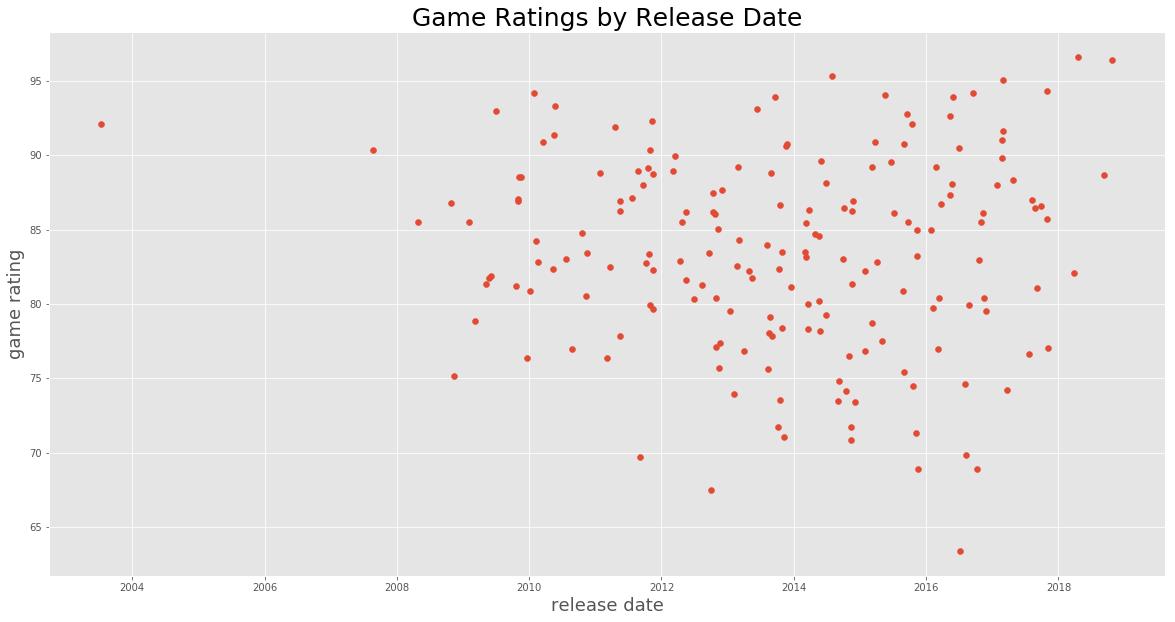

In [202]:
#create a scatter plot that plots each game in our df as a function of their total rating review score over the past 7 years
dt = pd.DatetimeIndex(df['release_date'])
dt
from scipy import stats

plt.style.use('ggplot')
new_figure = plt.figure(figsize=(20, 10))
ax = new_figure.add_subplot(111)
ax.scatter(dt, df['total_review_rating'])
ax.set_xlabel('release date', size=18)
ax.set_ylabel('game rating', size=18)
ax.set_title('Game Ratings by Release Date', size=25)

In [37]:
#needed to make a list of every game that is offered on all Xbox platforms
list_of_xbox_games = []

list_of_xbox_games = df.index[df['Xbox 360'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox One'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox Live Arcade'] == True].tolist()


#because games can be offered on more than one needed to create a unique list
unique_ls_xbox_games = list(set(list_of_xbox_games))


#now have a list of xbox games
len(unique_ls_xbox_games)


###repeat this for Playstation and Nintendo####

list_of_playstation_games = []

list_of_playstation_games = df.index[df['PS3'] == True].tolist()
list_of_playstation_games += df.index[df['PS4'] == True].tolist()
list_of_playstation_games += df.index[df['PlayStation Vita'] == True].tolist()
list_of_playstation_games += df.index[df['PlayStation Network'] == True].tolist()


unique_ls_playstation_games = list(set(list_of_playstation_games))

len(unique_ls_playstation_games)




list_of_nintendo_games = []

list_of_nintendo_games = df.index[df['Wii'] == True].tolist()
list_of_nintendo_games += df.index[df['Wii U'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo DS'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo 3DS'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo Switch'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo DSi'] == True].tolist()


unique_ls_nintendo_games = list(set(list_of_nintendo_games))

len(unique_ls_nintendo_games)


41

In [38]:
%matplotlib inline
!pip install matplotlib-venn

You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


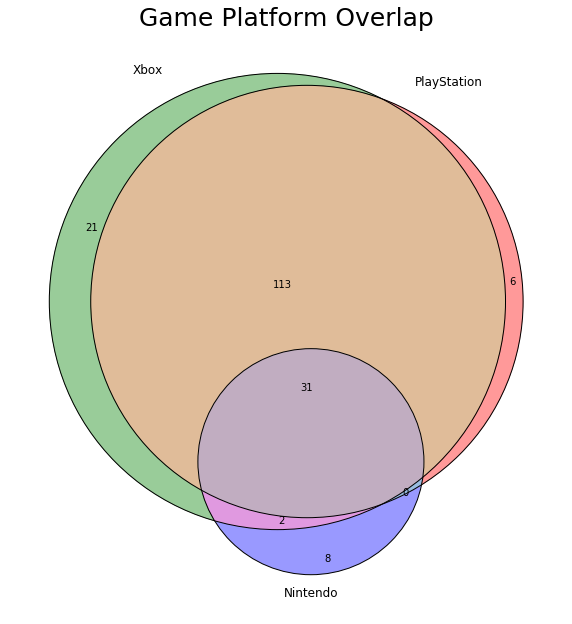

__Examining Games by Platform__

In [147]:
#get the mean for each column of relevant dummy variables for each of the three major gaming platforms

xbox = df[(df["Xbox One"] == True) | (df["Xbox"] == True) | (df["Xbox 360"] == True) | (df["Xbox Live Arcade"] == True)].mean()




#get the fraction of games for each major platform that fall into one of the column
ps = df[(df["PlayStation Vita"] == True) | (df["PS3"] == True) | (df["PS4"] == True) | (df["PlayStation Network"] == True)].mean()



#get the fraction of games for each major platform that fall into one of the column
nintendo = df[(df["Nintendo DS"] == True) | (df["Wii"] == True) | (df["Wii U"] == True) | (df["Nintendo 3DS"] == True) | (df["Nintendo DSi"] == True) | (df["Nintendo Switch"] == True)].mean()

In [40]:
#create a list of x values that correspond to the fraction of Playstation games by genre
y_ps = [ps['Simulator'], ps['Tactical'],
        ps['Quiz/Trivia'], ps['Fighting'], ps['Strategy'], ps['Adventure'],
        ps['Role-playing (RPG)'], ps['Shooter'], ps['Music'], ps['Indie'],
        ps['Turn-based strategy (TBS)'], ps['Pinball'], ps['Puzzle'],
        ps['Real Time Strategy (RTS)'], ps['Hack and slash/Beat ’em up'], ps['Platform'],
        ps['Racing'], ps['Sport'], ps['Point-and-click']]




#create a list of y values that corresponds to the name of each genre
x_ps = ['Simulator', 'Tactical','Quiz/Trivia', 
        'Fighting', 'Strategy', 'Adventure','RPG', 
        'Shooter', 'Music', 'Indie','TBS', 'Pinball', 
        'Puzzle','RTS','Beat em up', 'Platform','Racing', 
        'Sport','Point-and-click']

In [41]:
#create a list of x values that correspond the breakdown of Playstation games by genre

y_xbox = [xbox['Simulator'],xbox['Tactical'],
          xbox['Quiz/Trivia'], xbox['Fighting'], xbox['Strategy'], xbox['Adventure'],
          xbox['Role-playing (RPG)'], xbox['Shooter'], xbox['Music'], xbox['Indie'],
          xbox['Turn-based strategy (TBS)'], xbox['Pinball'], xbox['Puzzle'],
          xbox['Real Time Strategy (RTS)'], xbox['Hack and slash/Beat ’em up'], xbox['Platform'],
          xbox['Racing'], xbox['Sport'], xbox['Point-and-click']]
             
             


             
x_xbox = ['Simulator', 'Tactical',
          'Quiz/Trivia', 'Fighting', 'Strategy', 'Adventure',
          'RPG', 'Shooter', 'Music', 'Indie',
          'TBS', 'Pinball', 'Puzzle',
          'RTS','Beat em up', 'Platform',
          'Racing', 'Sport','Point-and-click']

In [42]:
#create a list of y values that correspond to the breakdown of Playstation games that have a true boolean value for a specific genre
y_nintendo = [
       nintendo['Simulator'], nintendo['Tactical'],
       nintendo['Quiz/Trivia'], nintendo['Fighting'], nintendo['Strategy'], nintendo['Adventure'],
       nintendo['Role-playing (RPG)'], nintendo['Shooter'], nintendo['Music'], nintendo['Indie'],
       nintendo['Turn-based strategy (TBS)'], nintendo['Pinball'], nintendo['Puzzle'],
       nintendo['Real Time Strategy (RTS)'], nintendo['Hack and slash/Beat ’em up'], nintendo['Platform'],
       nintendo['Racing'], nintendo['Sport'], nintendo['Point-and-click']
]

    #values for the x axis of our bar chart               
x_nintendo = [
        'Simulator', 'Tactical',
        'Quiz/Trivia', 'Fighting', 'Strategy', 'Adventure',
        'RPG', 'Shooter', 'Music', 'Indie',
        'TBS', 'Pinball', 'Puzzle',
        'RTS','Beat em up', 'Platform',
        'Racing', 'Sport','Point-and-click'
]

Text(0.5, 1.0, "Playstation's Game Breakdown By Genre")

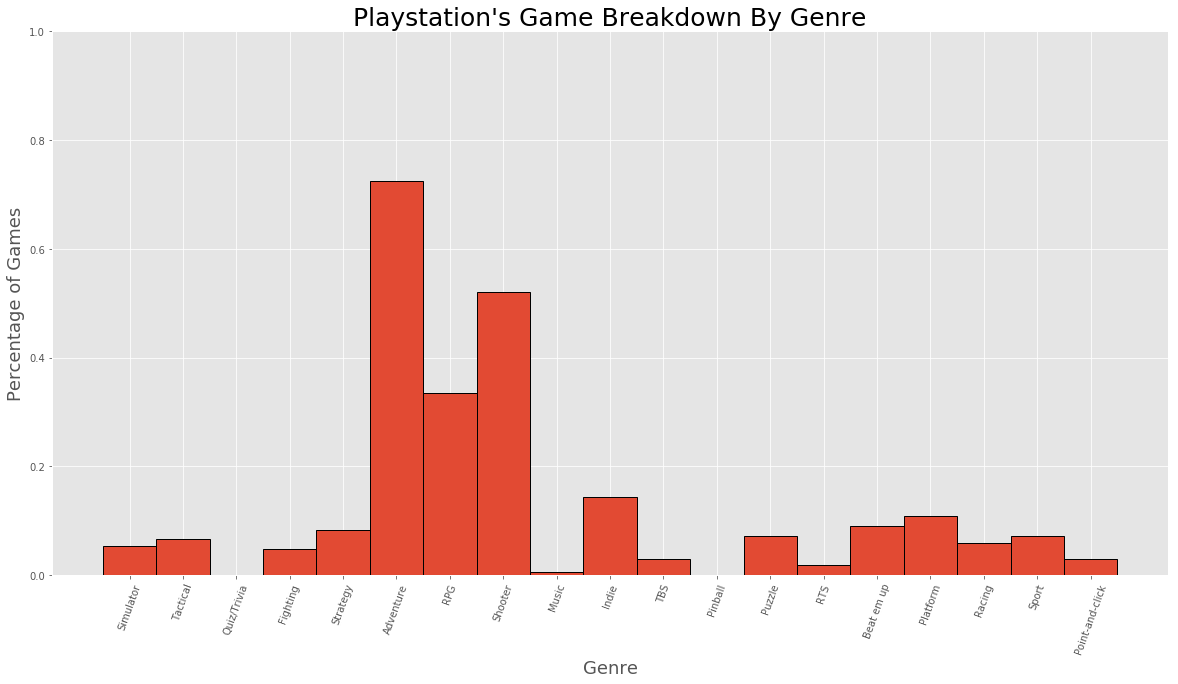

In [44]:
#create a bar plot that plots the previously calculated values for each major platform
new_figure_1= plt.figure(figsize=(20,10))
ax = new_figure_1.add_subplot(111, ylim = (0.0, 1.0))
ax.bar(x_ps, y_ps, width=1, bottom=None, edgecolor = 'black', linewidth = 1)
ax.set_xticklabels(x_ps, rotation=70)
ax.set_xlabel('Genre', size=18)
ax.set_ylabel('Percentage of Games', size = 18)
ax.set_title("Playstation's Game Breakdown By Genre", size=25)

Text(0.5, 1.0, 'Xbox Game Breakdown By Genre')

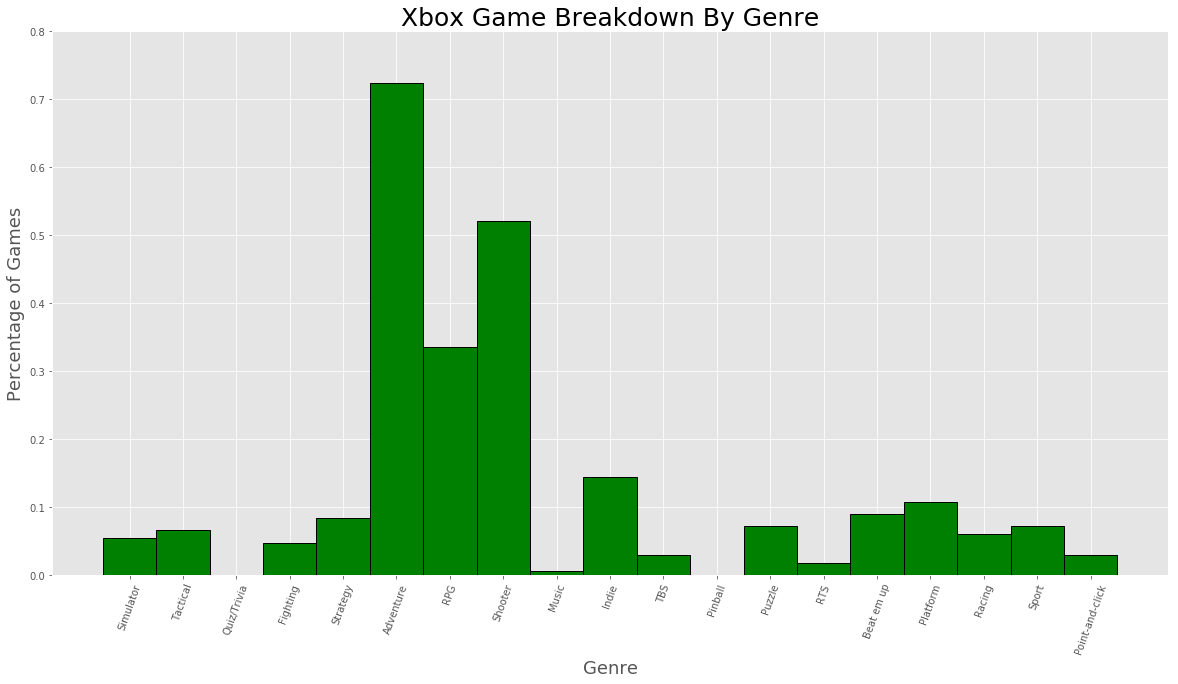

In [45]:
#repeat the previous plot but for Xbox games
new_figure_2= plt.figure(figsize=(20, 10))
ax2 = new_figure_2.add_subplot(111, ymargin=.01, ylim = (0.0, .8))
ax2.bar(x_ps, y_ps, width=1, bottom=None, edgecolor = 'black', linewidth = 1, color = 'green')
ax2.set_xticklabels(x_ps, rotation=70)
ax2.set_xlabel('Genre', size=18)
ax2.set_ylabel('Percentage of Games', size = 18)
ax2.set_title("Xbox Game Breakdown By Genre", size=25)

Text(0.5, 1.0, "Nintendo's Game Breakdown By Genre")

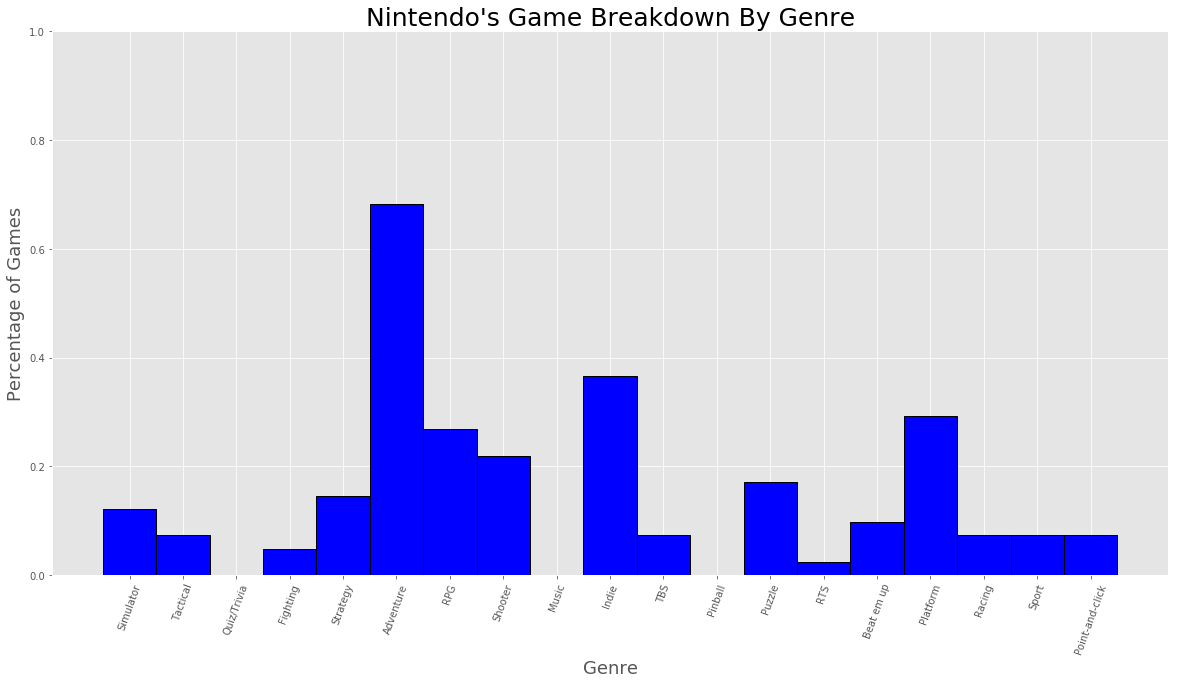

In [47]:
#repeat the previous plot but for Nintendo
new_figure_3 = plt.figure(figsize=(20,10))
ax3 = new_figure_3.add_subplot(111, ymargin=.01, ylim = (0.0, 1.0))#set y limits
ax3.bar(x_nintendo, y_nintendo, width=1, bottom=None, edgecolor = 'black', linewidth = 1, color='blue')
ax3.set_xticklabels(x_ps, rotation=70)#rotate the values on x axis as format
ax3.set_xlabel('Genre', size=18)
ax3.set_ylabel('Percentage of Games', size = 18)
ax3.set_title("Nintendo's Game Breakdown By Genre", size=25)

__Investigate the overlap between Game Platforms__

In [204]:
#needed to make a list of every game that is offered on all Xbox platforms
list_of_xbox_games = []

list_of_xbox_games = df.index[df['Xbox 360'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox One'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox Live Arcade'] == True].tolist()


#because games can be offered on more than one needed to create a unique list
unique_ls_xbox_games = list(set(list_of_xbox_games))


#now have a list of xbox games
len(unique_ls_xbox_games)


###repeat this for Playstation and Nintendo####

list_of_playstation_games = []

list_of_playstation_games = df.index[df['PS3'] == True].tolist()
list_of_playstation_games += df.index[df['PS4'] == True].tolist()
list_of_playstation_games += df.index[df['PlayStation Vita'] == True].tolist()
list_of_playstation_games += df.index[df['PlayStation Network'] == True].tolist()


unique_ls_playstation_games = list(set(list_of_playstation_games))

len(unique_ls_playstation_games)




list_of_nintendo_games = []

list_of_nintendo_games = df.index[df['Wii'] == True].tolist()
list_of_nintendo_games += df.index[df['Wii U'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo DS'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo 3DS'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo Switch'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo DSi'] == True].tolist()


unique_ls_nintendo_games = list(set(list_of_nintendo_games))


You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


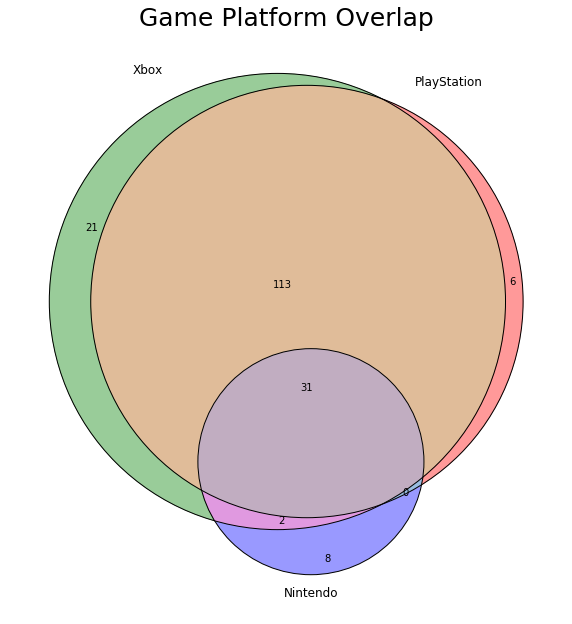

In [206]:
#given the unique assemblance of my data this takes in area.weight inputs and returns a venn-diagram 
%matplotlib inline
!pip install matplotlib-venn

from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
#need to find the overlap of games between each video game platform so convert our unique list of games offered for each platform into a set
A = unique_ls_playstation_games
B = unique_ls_xbox_games
C = unique_ls_nintendo_games
Abc = len(set(A)-set(B)-set(C)) 
aBc = len(set(B)-set(A)-set(C)) 
ABc = len(set(A)&set(B)-set(C)) 
abC = len(set(C)-set(A)-set(B)) 
AbC = len(set(A)&set(C)-set(B)) 
aBC = len(set(B)&set(C)-set(A)) 
ABC = len(set(A)&set(B)&set(C)) 
#using the lengths of the unique list that we set up earlier and checking the overlap between them using the bitwise operators we can create a list of area weighted overlaps for each section of our venn diagram 
#the set of values that it takes will be the weighted average of every combination of game_overlap
plt.figure(figsize=(10,15))
v = venn3(subsets=((Abc, aBc, ABc, abC, AbC, aBC, ABC)), set_labels = ('Xbox', 'PlayStation', 'Nintendo'))
c=venn3_circles(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), linestyle='solid', linewidth=1, color="black")
v.get_patch_by_id('A').set_color('green')
v.get_patch_by_id('B').set_color('red')
plt.title('Game Platform Overlap', size = 25)
plt.show()

__Exploring the Relationship Between User Rating and Critic Rating__

In [207]:
#getting a list of names for top 15 games sorted by total review rating in descending order
list(df.index[:15])

['God of War',
 'Red Dead Redemption 2',
 'The Last of Us Remastered',
 'The Legend of Zelda: Breath of the Wild',
 'Super Mario Odyssey',
 'Persona 5',
 'Mass Effect 2',
 'The Witcher 3: Wild Hunt',
 'Grand Theft Auto V',
 'The Witcher 3: Wild Hunt - Blood and Wine',
 'Super Mario Galaxy 2',
 'The Last of Us',
 'Uncharted 2: Among Thieves',
 'Undertale',
 "Uncharted 4: A Thief's End"]

In [208]:
#getting the corresponding critic_ratings and user_ratings for top 15 games
critic_review_top = list(df.critic_review_rating[:15])
user_review_top = list(df.player_review_rating[:15])

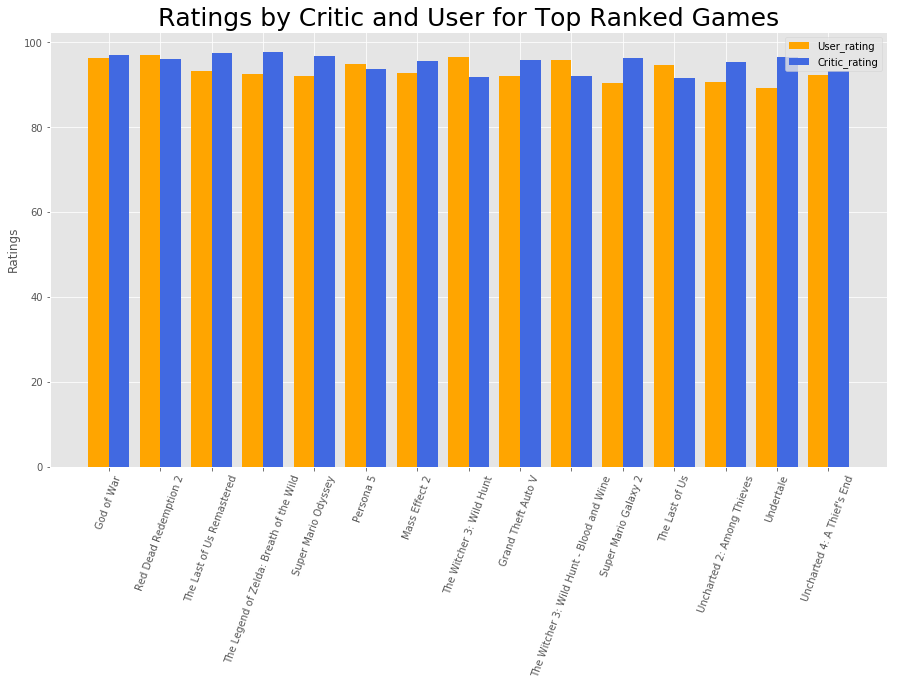

In [209]:
#starting to make a bar plot that has both user and critic rating for top 15 games

N = 15

ind = np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
#the bar plot for our user review ratings
rects1 = ax.bar(ind, user_review_top, width, color='orange')
user_rating = (user_review_top)
#the bar plot for our critic review ratings
critic_rating = (critic_review_top)
rects2 = ax.bar(ind+width, critic_review_top, width, color='royalblue')#seperate by the width of the bar 

# add some features 
ax.set_ylabel('Ratings')
ax.set_title('Ratings by Critic and User for Top Ranked Games', size =25)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ['God of War',
 'Red Dead Redemption 2',
 'The Last of Us Remastered',
 'The Legend of Zelda: Breath of the Wild',
 'Super Mario Odyssey',
 'Persona 5',
 'Mass Effect 2',
 'The Witcher 3: Wild Hunt',
 'Grand Theft Auto V',
 'The Witcher 3: Wild Hunt - Blood and Wine',
 'Super Mario Galaxy 2',
 'The Last of Us',
 'Uncharted 2: Among Thieves',
 'Undertale',
 "Uncharted 4: A Thief's End"], rotation = 70 )


ax.legend( (rects1[0], rects2[0]), ('User_rating', 'Critic_rating'))

plt.show()


In [210]:
#wanted to look at how the rankings appear for the bottom tier of games as well (bottom of the top 200 that is) 

In [211]:
list(df.index[-15:])

['Dead Space 3',
 'Batman: Arkham Origins',
 'The Sims 4',
 'Game of Thrones: A Telltale Games Series',
 "Assassin's Creed: Rogue",
 'Beyond: Two Souls',
 'Call of Duty: Black Ops III',
 'Call of Duty: Ghosts',
 "Assassin's Creed: Unity",
 "No Man's Sky",
 'Dead Island',
 'Mafia III',
 'Star Wars Battlefront',
 'Resident Evil 6',
 'Pokémon GO']

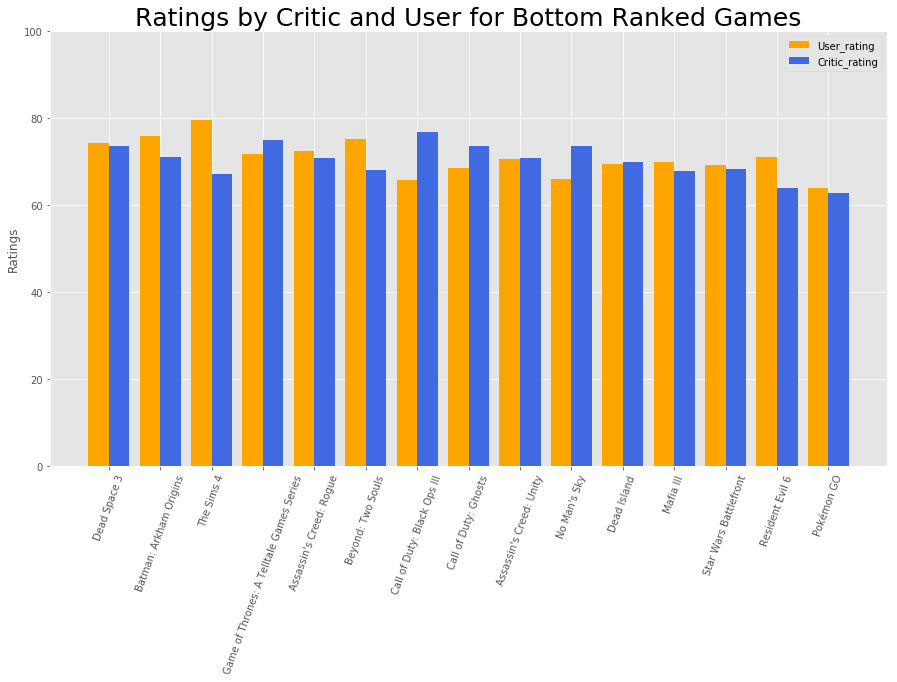

In [212]:
#wanted to look at how the rankings appear for the bottom tier of games as well (bottom of the top 200 that is) 

#create two variables that are lists of the corresponding user/critic rankings for bottom 15 games 
critic_review_bottom = list(df.critic_review_rating[-15:])
user_review_bottom = list(df.player_review_rating[-15:])


N = 15 #the number elements that are going to be plotted for each bar graph

ind = np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, user_review_bottom, width, color='orange')
user_rating = (user_review_top)

#need to offset the second column in our two bar graph by the width
critic_rating = (critic_review_top)
rects2 = ax.bar(ind+width, critic_review_bottom, width, color='royalblue')

# add the descriptive attributes for our plot 
ax.set_ylabel('Ratings')
ax.set_title('Ratings by Critic and User for Bottom Ranked Games', size =25)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ['Dead Space 3',
 'Batman: Arkham Origins',
 'The Sims 4',
 'Game of Thrones: A Telltale Games Series',
 "Assassin's Creed: Rogue",
 'Beyond: Two Souls',
 'Call of Duty: Black Ops III',
 'Call of Duty: Ghosts',
 "Assassin's Creed: Unity",
 "No Man's Sky",
 'Dead Island',
 'Mafia III',
 'Star Wars Battlefront',
 'Resident Evil 6',
 'Pokémon GO'], rotation = 70 )
ax.set_ylim(top = 100) 


ax.legend( (rects1[0], rects2[0]), ('User_rating', 'Critic_rating'))

plt.show()